In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import *
from collections import Counter
from heapq import nsmallest
import re
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction import DictVectorizer
from sklearn.cluster import KMeans
from sklearn.externals import joblib

In [2]:
path = '../data/eventclouds.npy'

data = np.load(path)

In [3]:
#data

In [4]:
def get_words_from_data(data):
    cat_list = []
    for id, event in data.item().items():
        # event
        for feature, resources in event.items():
            # dbpedia answers    
            cat_list.append(resources)

    # flatten
    return [item for sublist in cat_list for item in sublist]

In [5]:
def get_most_common(words, n):
    c = Counter(words)
    return [x[0] for x in c.most_common(n)]

In [6]:
word_list = get_words_from_data(data)
stop = get_most_common(word_list, 50)
stop.append('DULowlAgent')
stop.append('Agent')

In [7]:
def prepare_data(data, filter_data=[]):
    X = []
    for key, values in data.item().items():
        #event
        row = {}
        for feature, resources in values.items():
            
            # filter attributes
            if feature not in ['resources', 'categories']:
                continue
                #pass
            
            if filter_data:
                res = [x for x in resources if x not in filter_data]
            else:
                res = resources
            
            # change data format for vectorizing
            tmp = [feature + '=' + x for x in res]
            
            for entry in tmp:
                row[entry] = True
        X.append(row)
    return X

In [8]:
D = prepare_data(data, stop)

In [9]:
v = DictVectorizer(sparse=True)
X = v.fit_transform(D)

In [10]:
feature_occ = v.get_feature_names()

In [11]:
from sklearn.cluster import KMeans

num_clusters = 3

km = KMeans(n_clusters=num_clusters)

%time km.fit(X)

clusters = km.labels_.tolist()

CPU times: user 215 ms, sys: 1.31 ms, total: 216 ms
Wall time: 216 ms


In [12]:
test = km.transform(X)

In [13]:
def calculate_confidence(transformed_x):
    # calculate confidence
    scores = []
    for distances in transformed_x:
        #print(distances)
        dist = 100 - distances
        #norm = [float(i)/sum(dist) for i in dist]
        #print(norm)
        #confidence = min(norm)
        
        #use min dist for now
        confidence = min(distances)
        scores.append(confidence)
        
    return scores

In [14]:
confidences = calculate_confidence(test)

In [15]:
frame = pd.DataFrame(data.item()).transpose()
frame.columns = ['broader', 'categories', 'resources', 'subClassOf', 'types']
frame['cluster'] = pd.Series(clusters).values
frame['min_dist'] = pd.Series(confidences).values
frame.reset_index(level=0, inplace=True)

In [16]:
frame.head()

,index,broader,categories,resources,subClassOf,types,cluster,min_dist
0,004edefe-4d2b-41f9-aa08-7b31a00be98a,"[CategoryPoliticalpartywings, Category1933esta...","[CategoryAdolfHitler, CategoryNaziPartyorganiz...",[Sturmabteilung],"[Agent, WikicatParamilitaryOrganizationsOfTheW...",[DBpediaAgentSchemaOrganizationDBpediaOrganisa...,0,7.304355
1,00bd553c-01a3-40f0-bb92-0b65e613e3ab,"[CategoryTelevisionseriesbystudio, CategoryEng...",[CategoryTelevisionseriesbyUniversalTelevision...,"[SmashTVseries, Bros]","[Agent, Ending106308765, TelevisionShow, Actio...",[SchemaCreativeWorkDBpediaWorkDBpediaTelevisio...,0,2.594642
2,00cd0148-2e35-4077-86a9-d9da8528a6bc,"[CategoryArtsoccupations, CategoryWikipediacat...",[CategoryPopulatedplacesestablishedinthe13thce...,"[Makeupartist, Berlin]","[Location100027167, WikicatStatesAndTerritorie...",[SchemaPlaceDBpediaPlaceDBpediaPopulatedPlaceD...,0,16.745043
3,038a05d1-5315-4470-87ea-5e8522bc67b7,[CategoryEntertainmentcompaniesestablishedin20...,"[CategoryRecordlabelsestablishedin2006, Catego...","[MercedesBenzArena, Berlin, Fireworks, Fascina...","[SocialEvent107288639, PhysicalEntity100001930...",[SchemaPlaceDBpediaPlaceDBpediaSportFacilitySc...,0,3.006545
4,03a1921a-869a-444d-9963-0cfa56c135f1,"[CategoryNationalsportsteamsofTogo, CategoryAs...","[CategoryTogonationalfootballteam, CategoryAfr...",[Togonationalfootballteam],"[Team108208560, SoccerClub, Agent, YagoLegalAc...",[DBpediaAgentSchemaOrganizationDBpediaOrganisa...,0,3.430435


In [17]:
lookup = np.load('../data/event_lookup.npy')
lookup = pd.DataFrame(lookup, columns = ['index', 'title'])
lookup.head()

#frame.loc['-KcBAZuiALnRgx2KE0yN']
#df.head()

,index,title
0,39901055-b448-4c16-8c9a-27d8ed7eff3b,Stimmen aus Tschernobyl - Chronik der Zukunft
1,72034943-c426-4911-b239-25f26beb48df,Anamnese in der HPP Praxis
2,f0a72c38-9ab6-4c4c-a91b-6211de9b1167,Lady's Night
3,52c35a5c-1a0a-478f-972c-a40280579847,Vodka Energy Party
4,bf08460d-4223-4d21-bd24-b134681583dd,Tag der offenen Tür


In [18]:
hansi = pd.merge(frame, lookup, how='left', on='index')

In [19]:
hansi['cluster'].value_counts()

0    280
2     33
1     15
Name: cluster, dtype: int64

In [20]:
def clean_string(string, regex=r'[a-zA-Z0-9]*='):
    """
    clean string by removing non chars
    """
    tmp = re.sub(regex, '', string)
    return re.sub('(?<=[a-zA-Z])\d+$', '', tmp)

In [30]:
from __future__ import print_function

print("Top terms per cluster:")
print()

top_n = 20

order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster: {i}, Entries: {e}, top {t} features: \n".format(i = i, e = hansi['cluster'].value_counts()[i], t = top_n))
    for ind in order_centroids[i, :top_n]:
        #print(ind)
        feature = v.get_feature_names()[ind]
        print(clean_string(feature))
        #print(feature)
    print()
    print()

Top terms per cluster:

Cluster: 0, Entries: 280, top 20 features: 

CategoryMembersoftheHanseaticLeague
CategoryPopulatedplacesestablishedinthe13thcentury
CategoryBerlin
Category1237establishments
CategoryArticlescontainingvideoclips
CategoryDisco
CategoryAfricanAmericanmusic
CategoryMediaoccupations
CategoryOccupationsinmusic
CategoryUniversitytownsinGermany
Discjockey
CategoryDJing
CategoryAudiomixing
CategoryBroadcastingoccupations
CategoryLivingpeople
CategoryRadiopresenters
CategoryMemberstatesoftheUnitedNations
CategoryFormerboroughsofBerlin
CategoryLiberaldemocracies
CategoryLocalitiesofBerlin


Cluster: 1, Entries: 15, top 20 features: 

CategoryStresstimedlanguages
CategoryLanguagesofIreland
CategoryLanguagesofSingapore
CategoryLanguagesoftheSolomonIslands
CategoryLanguagesofLiberia
CategoryLanguagesofLesotho
CategoryLanguagesofKiribati
CategoryLanguagesofKenya
CategoryLanguagesofJamaica
CategoryEnglishlanguages
CategoryLanguagesofIndia
CategoryLanguagesofSouthSudan
CategoryL

In [22]:
from sklearn.externals import joblib

joblib.dump(km,  '../data/doc_cluster.pkl')
#km = joblib.load('../data/doc_cluster.pkl')


['../data/doc_cluster.pkl']

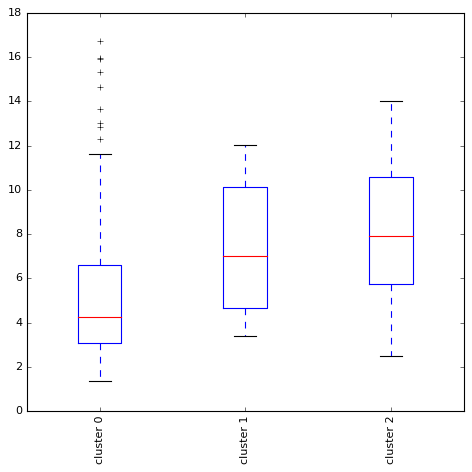

In [36]:
plt.figure(figsize=(6, 6))
liste = []
labels = []
for i in range(num_clusters):
    #print(hansi.loc[hansi['cluster'] == i]['min_dist'].values)
    tmp = hansi.loc[hansi['cluster'] == i]['min_dist'].values
    liste.append(tmp)
    labels.append('cluster {}'.format(i))
plt.boxplot(liste)
plt.xticks(range(1,4), labels, rotation='vertical')
plt.tight_layout()
plt.savefig('confidence.png')
plt.show()


In [24]:
top_5 = hansi.sort_values(by=['min_dist'],ascending=True).groupby('cluster').head(5)

In [25]:
top_5.loc[top_5['cluster'] == 1]['title']

26                               Die Jungs von Bibi&Tina
124                    Creepy Crypt no.45: Sneak Preview
162    PASCOW - Dosenbier und Popcorn noir // Conne I...
262                                  Der Audi Q5- Brunch
313    J S Bach Kantate Nr 156 Ich steh mit einem Fuß...
Name: title, dtype: object

In [26]:
n = 15

print('Top {} titles per cluster:'.format(n))
print()
for i in range(num_clusters):
    print('cluster {}:'.format(i))
    tmp = hansi.sort_values(by=['min_dist'],ascending=True).groupby('cluster').head(n)
    titles = tmp.loc[tmp['cluster'] == i]['title']
    for entry in titles:
        print(entry)
    print()
    

Top 15 titles per cluster:

cluster 0:
Boot Düsseldorf
Grand Acid + Shaun
Oscar Mulero, Rebekah im Lehmann Club
Herr Kluge und ein Dinosaurier in der Schule
BoomFit Training im Volkspark Friedrichshain
Der Audi Q-Brunch
Astronavigationstörn / SHS Ausbildungstörn
Morgenprogramm
Wir haben es satt! – Demonstration
EuroPendent Rock mit Straight Ahead, Opalaxy, KOA, Blue Medow
Crafts & Cakes
Pferde Rouladenessen
Papa Kangatraining in Charlottenburg
Marepe: Suave na nave
Stoffmarkt am Maybachufer

cluster 1:
Die Jungs von Bibi&Tina
Creepy Crypt no.45: Sneak Preview
PASCOW - Dosenbier und Popcorn noir // Conne Island Leipzig
Der Audi Q5- Brunch
J S Bach Kantate Nr 156 Ich steh mit einem Fuß im Grabe
Action-Sport auf der Messe boot
Another Saturday Night feat. Michael Brinkworth &30th Bday bash!
Auswärtsspiel gegen City Basket Berli
BERLinsane // Sa 21. Januar // Matrix
Watergate Showcase w/ Matthias Meyer y Hyenah
CRAZY SEXY POWERFUL Workshop by KIM STOLIC
D R E a M T I M E F I N I S S a G E


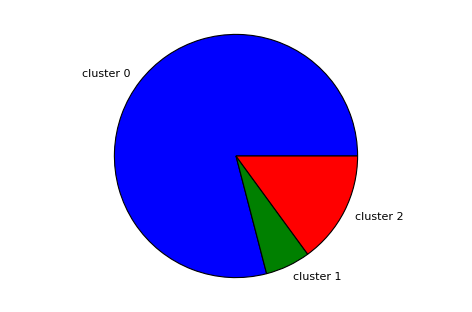

In [33]:
sums = hansi['min_dist'].groupby(hansi.cluster).sum()
plt.axis('equal')
plt.pie(sums, labels=['cluster {}'.format(x) for x in sums.index])
plt.tight_layout()
plt.savefig('pie.png')
plt.show()